# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Q1. Interactive Foreground Segmentation Using K-Means Clustering 

In [30]:
# Function for K-mean clustering using numpy

def updated_centroids(data , clusters , k):
    
    centroids = np.zeros((k, data.shape[1]))
    for i in range(k):
        cluster_points = data[clusters == i]
        if len(cluster_points) > 0:
            centroids[i] = cluster_points.mean(axis = 0)
    return centroids

def kmeans(data , k):
    
    max_iters = 100
    
    #Initial centriods for the given data
    indices = np.random.choice(len(data), k , replace = False)
    centroids = data[indices]
    
    for i in range(max_iters):
        
        prev_centroids = centroids.copy()
        
        # Assigning clusters to the datapoints by calculating euclidean distance
        distances = np.sqrt(((data - centroids[:,np.newaxis])**2).sum(axis = 2))
        clusters = np.argmin(distances, axis = 0)
        
        # Updating the new centroids 
        
        centroids = updated_centroids(data, clusters, k)
        
        # Check for convergence i.e if the current centroids is same as prev
        
        if np.allclose(prev_centroids, centroids):
            break
    return clusters, centroids

In [3]:
def Red_Check(aux_img):
    
 # Define the range for red color

    red_range = ([200, 0, 0], [255, 100, 100]) 
    red_range_with_alpha = ([200, 0, 0, 0], [255, 100, 100, 255]) 
    
 # Iterate through the array and check if any element falls within the blue range
    color_found = False
    for row in aux_img:
        for pixel in row:
            if len(pixel) == 3:
                # Check if the pixel falls within the range for blue without alpha
                if (red_range[0][0] <= pixel[0] <= red_range[1][0] and
                    red_range[0][1] <= pixel[1] <= red_range[1][1] and
                    red_range[0][2] <= pixel[2] <= red_range[1][2]):
                    color_found = True
                    red = pixel.tolist()
                    break
            elif len(pixel) == 4:
                # Check if the pixel falls within the range for blue with alpha
                if (red_range_with_alpha[0][0] <= pixel[0] <= red_range_with_alpha[1][0] and
                    red_range_with_alpha[0][1] <= pixel[1] <= red_range_with_alpha[1][1] and
                    red_range_with_alpha[0][2] <= pixel[2] <= red_range_with_alpha[1][2] and
                    red_range_with_alpha[0][3] <= pixel[3] <= red_range_with_alpha[1][3]):
                    color_found = True
                    red = pixel.tolist()
                    break
        if color_found:
            break

    return red  

In [4]:
def Blue_Check(aux_img):
    
    blue = []
    
    # Define the range for blue color
    blue_range = ([0, 0, 200], [100, 100, 255])  # Adjust the range for 3 indices
    blue_range_with_alpha = ([0, 0, 200, 0], [100, 100, 255, 255])  # Adjust the range for 4 indices

    # Iterate through the array and check if any element falls within the blue range
    color_found = False
    for row in aux_img:
        for pixel in row:
            if len(pixel) == 3:
                # Check if the pixel falls within the range for blue without alpha
                if (blue_range[0][0] <= pixel[0] <= blue_range[1][0] and
                    blue_range[0][1] <= pixel[1] <= blue_range[1][1] and
                    blue_range[0][2] <= pixel[2] <= blue_range[1][2]):
                    color_found = True
                    blue = pixel.tolist()
                    break
            elif len(pixel) == 4:
                # Check if the pixel falls within the range for blue with alpha
                if (blue_range_with_alpha[0][0] <= pixel[0] <= blue_range_with_alpha[1][0] and
                    blue_range_with_alpha[0][1] <= pixel[1] <= blue_range_with_alpha[1][1] and
                    blue_range_with_alpha[0][2] <= pixel[2] <= blue_range_with_alpha[1][2] and
                    blue_range_with_alpha[0][3] <= pixel[3] <= blue_range_with_alpha[1][3]):
                    color_found = True
                    blue = pixel.tolist()
                    break
        if color_found:
            break

    return blue

In [5]:
# Extract seed pixels for foreground and background classes
def extract_pixels(image, seed_coordinates):
    pixels = image[seed_coordinates[:, 0], seed_coordinates[:, 1]]
    return pixels

In [6]:
# Function to compute likelihood of pixels

def likelihood(pxl, cluster_centroid, wk):
    distance = np.linalg.norm(pxl - cluster_centroid)
    return np.exp(-wk * distance)

def fg_bg_classification(pxls, fg_clusters, bg_clusters, wk):
    
    pxl_fg = np.zeros(len(pxls))
    pxl_bg = np.zeros(len(pxls))

    for i, pxl in enumerate(pxls):
        
        for j, fg_cluster in enumerate(fg_clusters):
            
            pxl_fg[i] += likelihood(pxl , fg_cluster , wk)
            
        for j, bg_cluster in enumerate(bg_clusters):
            
            pxl_bg[i] += likelihood(pxl, bg_cluster, wk)

    return pxl_fg, pxl_bg

In [9]:
def img_segmentation(real_img , fg_seeds , bg_seeds , N , wk = 0.1):
    
    # Reshaping the image for K-means

    X = np.reshape(real_img, (-1, 3))

    # Step 1 : Perform K-means clustering on color pixels

    cluster_indices, cluster_centroids = kmeans(X , N)

    # Step 2 : Extract seed pixels for foreground and background classes 

    fg_pixels = extract_pixels(real_img, fg_seeds)
    bg_pixels = extract_pixels(real_img, bg_seeds)

    # Step 3 : Using K-means function to obtain N clusters for each class.

    fg_indexes, fg_centroids = kmeans(fg_pixels, N)
    bg_indexes, bg_centroids = kmeans(bg_pixels, N)

    # Step 4 : Computing the likelihood of a given pixel to belong to each of the N clusters of a given class

    pxl_fg, pxl_bg = fg_bg_classification(X , fg_centroids, bg_centroids, wk)

    # Step 5 : Assign each pixel to a class i.e foreground / background

    sg_img = np.zeros(len(X))
    sg_img[pxl_fg > pxl_bg] = 1
    sg_img = np.reshape(sg_img, real_img.shape[:2])


    return sg_img

In [53]:
def display_img(sg_img):
    
    plt.imshow(sg_img , cmap = 'gist_gray')
    plt.axis('off')
    plt.show()

In [51]:
# Load original and auxiliary images

orig_img = np.array(Image.open("lady.png"))
aux_img = np.array(Image.open("lady stroke 1.png"))

# Checking and extracting RGB values

blue = Blue_Check(aux_img)

red = Red_Check(aux_img)

# Extract foreground and background seed from auxiliary image

fg_seeds = np.argwhere(np.all(np.abs(aux_img - red) < 10, axis=-1))
bg_seeds = np.argwhere(np.all(np.abs(aux_img - blue) < 10, axis=-1))


# Image segmentation using lazy snapping

N = 64

segmented_img = img_segmentation(orig_img, fg_seeds , bg_seeds , N)

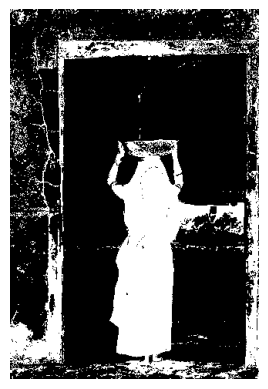

In [54]:
display_img(segmented_img)

# Experimentation with different N-values

In [55]:
N = 16

n_segmented_img = img_segmentation(orig_img, fg_seeds , bg_seeds , N)

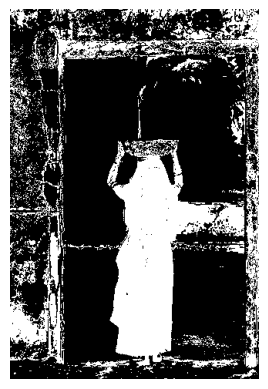

In [56]:
display_img(n_segmented_img)

# Mona-lisa

In [46]:
# Load original and auxiliary images

orig_img = np.array(Image.open("Mona-lisa.png"))
aux_img = np.array(Image.open("Mona-lisa stroke 1.png"))

# Checking and extracting RGB values

blue = Blue_Check(aux_img)

red = Red_Check(aux_img)

# Extract foreground and background seed from auxiliary image

fg_seeds = np.argwhere(np.all(np.abs(aux_img - red) < 10, axis=-1))
bg_seeds = np.argwhere(np.all(np.abs(aux_img - blue) < 10, axis=-1))


# Image segmentation using lazy snapping

N = 64

segmented_img = img_segmentation(orig_img, fg_seeds , bg_seeds , N)

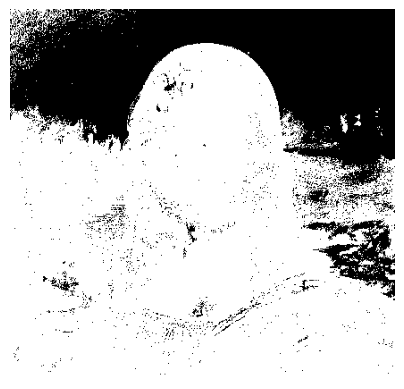

In [47]:
display_img(segmented_img)

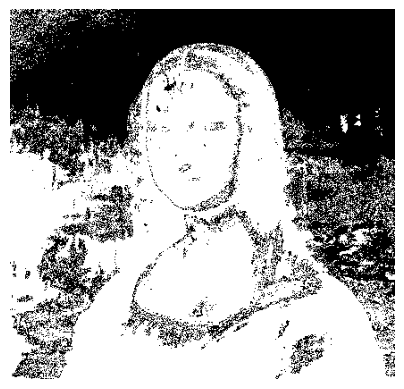

In [48]:
N = 32

new_segmented_img = img_segmentation(orig_img, fg_seeds , bg_seeds , N)

display_img(new_segmented_img)

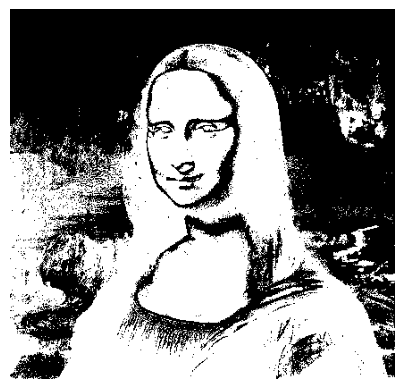

In [50]:
N = 16

new_segmented_img = img_segmentation(orig_img, fg_seeds , bg_seeds , N)

display_img(new_segmented_img)

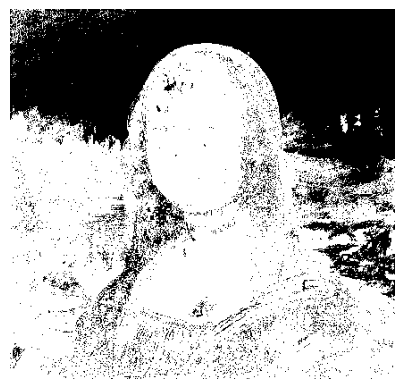

In [57]:
N = 72

b_segmented_img = img_segmentation(orig_img, fg_seeds , bg_seeds , N)

display_img(b_segmented_img)

# Van Gogh

In [40]:
# Load original and auxiliary images

orig_img = np.array(Image.open("van Gogh.png"))
aux_img = np.array(Image.open("van Gogh stroke.png"))

# Checking and extracting RGB values

blue = Blue_Check(aux_img)

red = Red_Check(aux_img)

# Extract foreground and background seed from auxiliary image

fg_seeds = np.argwhere(np.all(np.abs(aux_img - red) < 10, axis=-1))
bg_seeds = np.argwhere(np.all(np.abs(aux_img - blue) < 10, axis=-1))


# Image segmentation using lazy snapping

N = 16

segmented_img = img_segmentation(orig_img, fg_seeds , bg_seeds , N)

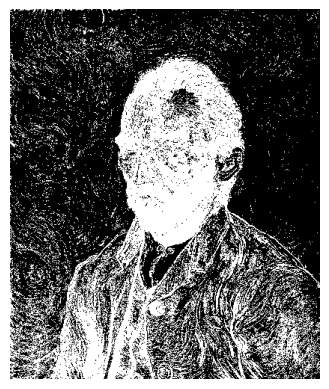

In [44]:
display_img(segmented_img)